In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from itertools import combinations
import anndata
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random

import plotting_functions as pf

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
plate_palette = sns.color_palette("husl", n_colors=3)
geno_palette = ['#DA9CC1', '#F4C245', '#C0BFBF', '#55AF5B', '#4F6EAF', '#52A5DB', '#D83026', '#683C91']


# QC plotting - 200 /500 UMI merged adata

In [3]:
adata = sc.read("../IGVF_analysis/preprocessed_tissues/GonadsFemalepreprocessed.h5ad")


In [4]:
adata.layers['raw_counts'] = adata.X.copy()


In [5]:
adata

AnnData object with n_obs × n_vars = 1187438 × 56953
    obs: 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'subpool', 'bc1_well', 'bc2_well', 'bc3_well', 'Mouse_Tissue_ID', 'alias_tissue1', 'alias_tissue2', 'alias_tissue3', 'alias_tissue4', 'plate', 'Protocol', 'Chemistry', 'well_type', 'Row', 'Column', 'Genotype', 'Notes', 'Multiplexed_sample1', 'Multiplexed_sample2', 'SampleType', 'Tissue', 'Tissue_ID', 'Tissue1_ontology_id', 'Tissue2_ontology_id', 'Sex', 'Replicate', 'DOB', 'Age_weeks', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Dissector', 'Tissue_weight_mg', 'mult_genotype_1', 'mult_genotype_2', 'mult_genotype', 'n_counts', 'WSBJ', 'NZOJ', '129S1J', 'CASTJ', 'B6J', 'NODJ', 'AJ', 'PWKJ', 'doublet_scores', 'batch'
    var: 'gene_name'
    layers: 'raw_counts'

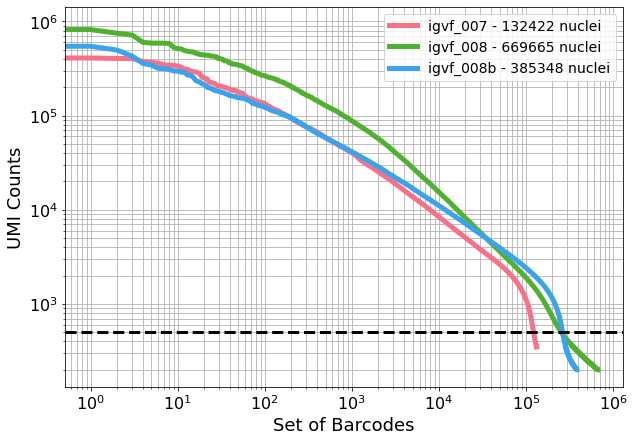

In [6]:
pf.plot_knee(adata, cutoff=500, category_column='plate', figsize=(10, 7))
plt.show()

In [7]:
# set var names to be gene names, not gene ID
adata.var_names  = adata.var['gene_name']
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


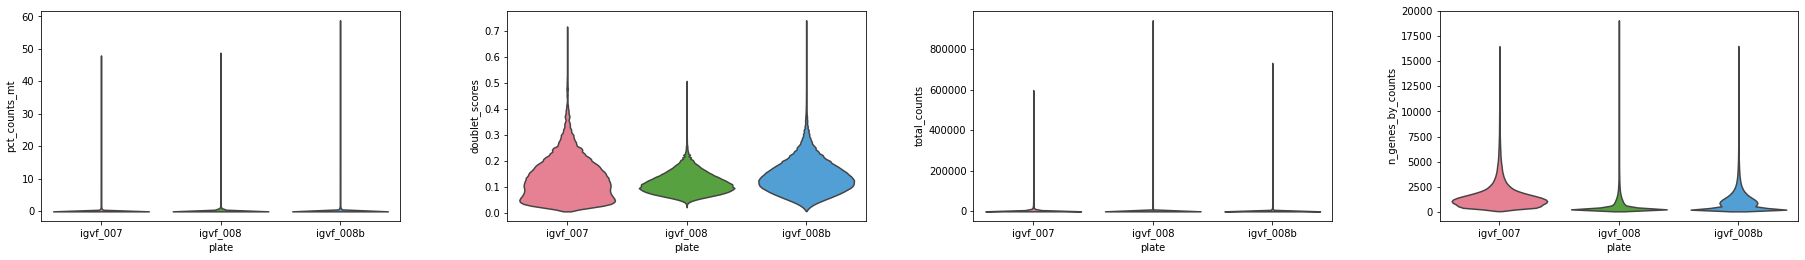

In [8]:
plate_palette = sns.color_palette("husl", n_colors=3)

sc.pl.violin(adata, ['pct_counts_mt', 'doublet_scores', 'total_counts', 'n_genes_by_counts'],
             groupby = "plate", palette = plate_palette,
             jitter=0.4, multi_panel=True, size=0)

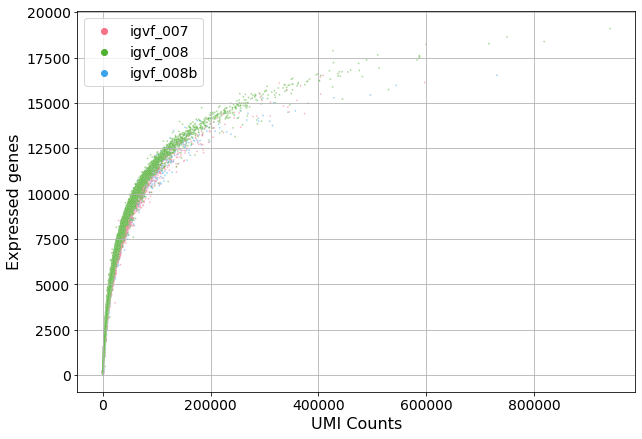

In [9]:
pf.plot_genes_by_counts(adata, category_column='plate', figsize=(10, 7))
plt.show()

In [10]:
adatas = adata[(adata.obs['total_counts'] < 10000) & (adata.obs['n_genes_by_counts'] < 2000), :]


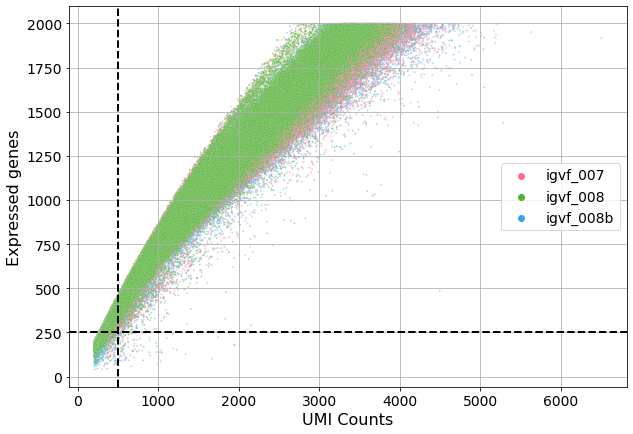

In [11]:
pf.plot_genes_by_counts(adatas, category_column='plate', figsize=(10, 7))

plt.axvline(x=500, color='k', linestyle='--', linewidth=2)
plt.axhline(y=250, color='k', linestyle='--', linewidth=2)

plt.show()

In [12]:
adatas[(adatas.obs['total_counts'] > 500) & (adatas.obs['n_genes_by_counts'] < 250), :]


View of AnnData object with n_obs × n_vars = 113 × 56953
    obs: 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'subpool', 'bc1_well', 'bc2_well', 'bc3_well', 'Mouse_Tissue_ID', 'alias_tissue1', 'alias_tissue2', 'alias_tissue3', 'alias_tissue4', 'plate', 'Protocol', 'Chemistry', 'well_type', 'Row', 'Column', 'Genotype', 'Notes', 'Multiplexed_sample1', 'Multiplexed_sample2', 'SampleType', 'Tissue', 'Tissue_ID', 'Tissue1_ontology_id', 'Tissue2_ontology_id', 'Sex', 'Replicate', 'DOB', 'Age_weeks', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Dissector', 'Tissue_weight_mg', 'mult_genotype_1', 'mult_genotype_2', 'mult_genotype', 'n_counts', 'WSBJ', 'NZOJ', '129S1J', 'CASTJ', 'B6J', 'NODJ', 'AJ', 'PWKJ', 'doublet_scores', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw_counts'

# QC plotting - filtered data
500 UMI, 250 genes, 1% mito, 0.25 doublet score


In [3]:
adata = sc.read("../IGVF_analysis/tissue_processed_500umi/GonadsFemale_processed.h5ad")


In [51]:
print(adata.obs['Genotype'].value_counts())

adata = adata[adata.obs['Genotype'] != "tie",:]

print(adata.obs['Genotype'].value_counts())

Genotype
NODJ      89835
AJ        76108
129S1J    74642
NZOJ      72676
PWKJ      70541
WSBJ      70186
B6J       69699
CASTJ     65117
tie          24
Name: count, dtype: int64
Genotype
NODJ      89835
AJ        76108
129S1J    74642
NZOJ      72676
PWKJ      70541
WSBJ      70186
B6J       69699
CASTJ     65117
Name: count, dtype: int64


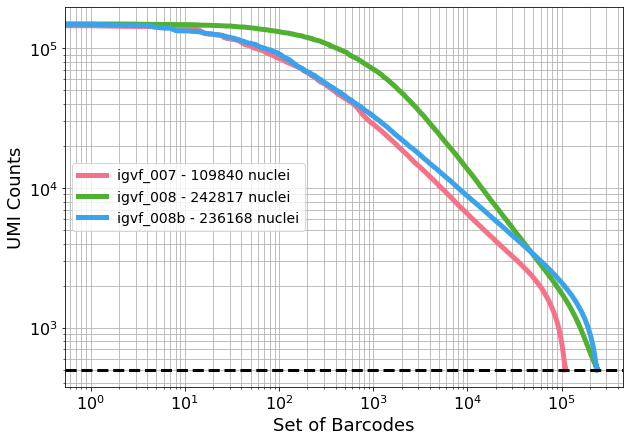

In [15]:
pf.plot_knee(adata, cutoff=500, category_column='plate', figsize=(10, 7))
plt.show()

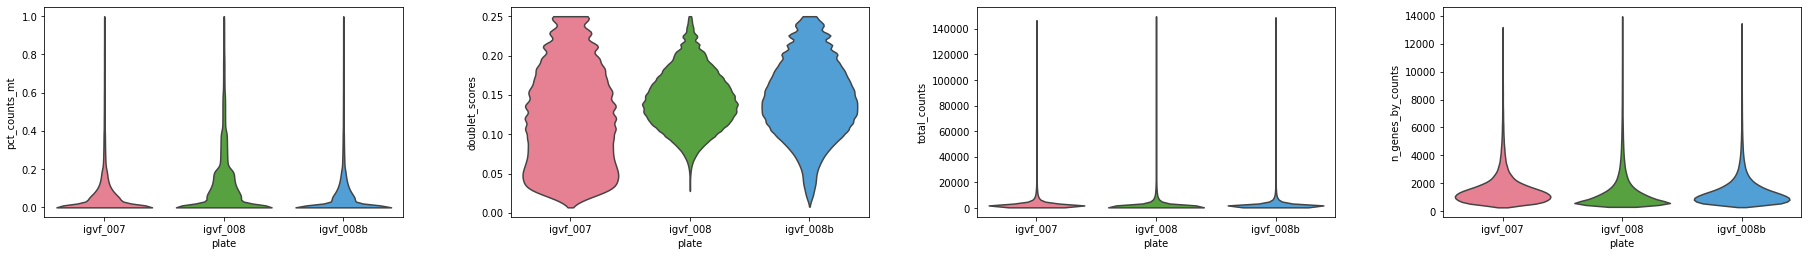

In [16]:
sc.pl.violin(adata, ['pct_counts_mt', 'doublet_scores', 'total_counts', 'n_genes_by_counts'],
             groupby = "plate", palette = plate_palette,
             jitter=0.4, multi_panel=True, size=0)

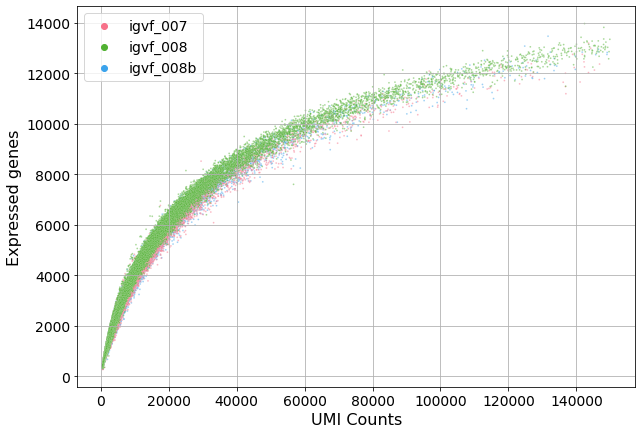

In [17]:
pf.plot_genes_by_counts(adata, category_column='plate', figsize=(10, 7))
plt.show()

# Check clustering
Plate, sex, genotype

In [ ]:
#sc.tl.leiden(adata, resolution = 2)


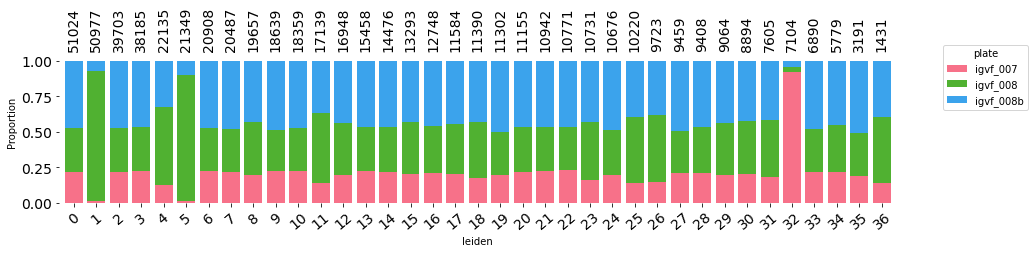

In [19]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'plate',
                            flip=False, fsize = (15,3), 
                            annotations = True)


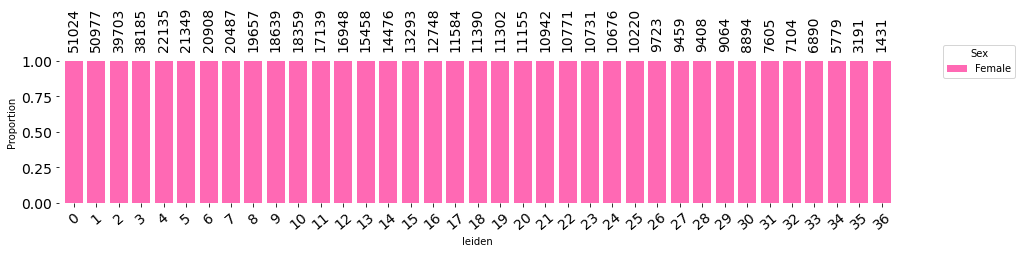

In [20]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'Sex',
                            flip=False, fsize = (15,3), 
                            annotations = True)


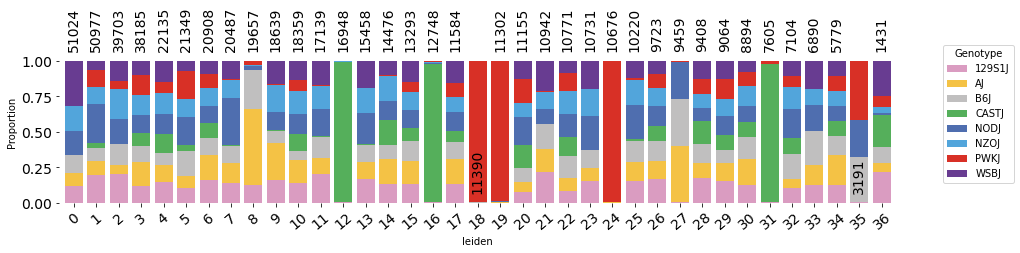

In [21]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'Genotype',
                            flip=False, fsize = (15,3), 
                            annotations = True)


In [52]:
# adjust mouse_tissue_id
# sample genotypes for each 'Multiplexed_sampleN'
ms1 = ['B6J','AJ','WSBJ','129S1J']
ms2 = ['NODJ','PWKJ','NZOJ','CASTJ']

# Define a function to update 'Mouse_Tissue_ID' based on conditions
def update_mouse_tissue_id(row):
    if row['plate'] != 'igvf_012' and row['Column'] in [9.0, 10.0, 11.0, 12.0]:
        if row['Genotype'] in ms1:
            return row['Multiplexed_sample1']
        elif row['Genotype'] in ms2:
            return row['Multiplexed_sample2']
    return row['Mouse_Tissue_ID']


# Apply the function to update the 'Mouse_Tissue_ID' column
adata.obs['Mouse_Tissue_ID'] = adata.obs.apply(update_mouse_tissue_id, axis=1)

/tmp/ipykernel_3769760/1190077505.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Mouse_Tissue_ID'] = adata.obs.apply(update_mouse_tissue_id, axis=1)


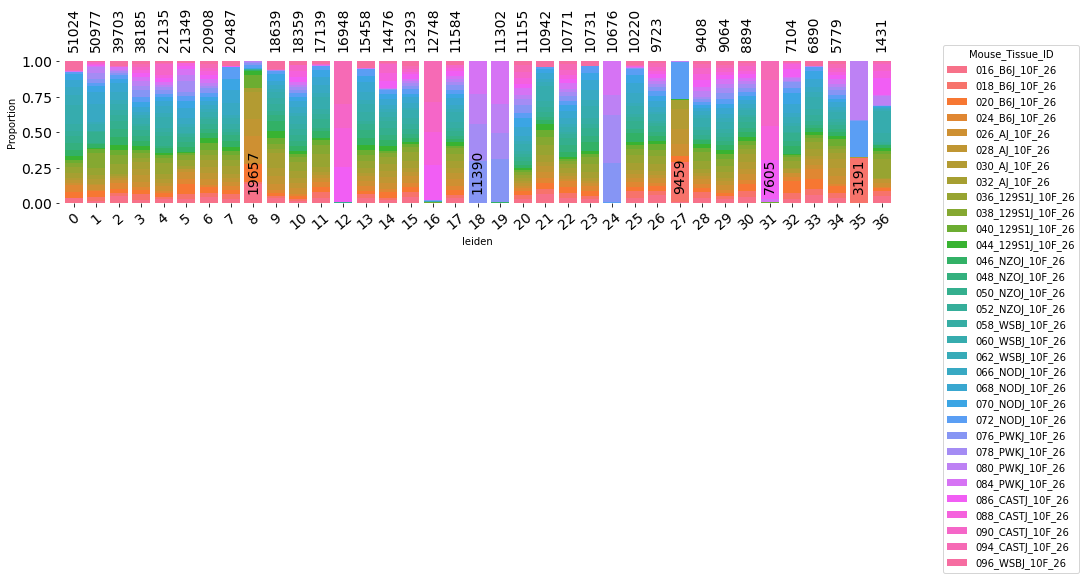

In [53]:
pf.stacked_barplot_proportions(adata.obs, 
                               'leiden', 'Mouse_Tissue_ID',
                               flip=False, fsize = (15,3), 
                               annotations = True)

In [54]:
df = adata.obs[['Mouse_Tissue_ID','Estrus_cycle','plate']]
df['Estrus_cycle'] = df['Estrus_cycle'].mask(df['Estrus_cycle'].eq('NA'), pd.NA)
df['Estrus_cycle'] = df.groupby('Mouse_Tissue_ID')['Estrus_cycle'].transform(lambda group: group.ffill().bfill())
df['Estrus_cycle'] = df['Estrus_cycle'].astype('str').replace('nan', 'NA')
df['Estrus_cycle'].value_counts()
adata.obs['Estrus_cycle'] = df['Estrus_cycle']

/tmp/ipykernel_3769760/1127546070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Estrus_cycle'] = df['Estrus_cycle'].mask(df['Estrus_cycle'].eq('NA'), pd.NA)
/tmp/ipykernel_3769760/1127546070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Estrus_cycle'] = df.groupby('Mouse_Tissue_ID')['Estrus_cycle'].transform(lambda group: group.ffill().bfill())
/tmp/ipykernel_3769760/1127546070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

Estrus_cycle
Diestrus             197396
Estrus               162597
Metestrus             97076
Proestrus             58485
NA                    56601
DiestrusProestrus     16649
Name: count, dtype: int64

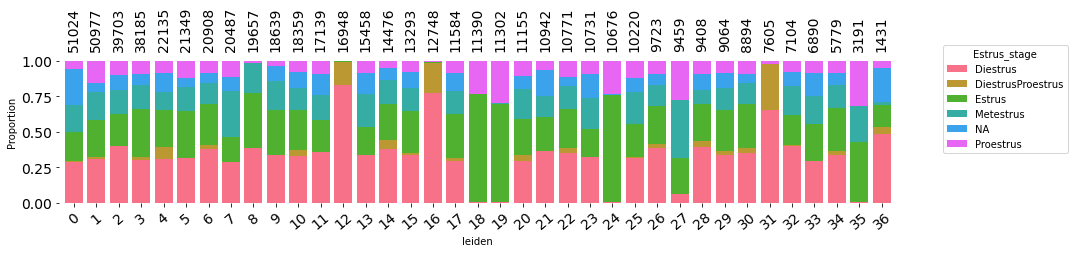

In [56]:
pf.stacked_barplot_proportions(adata.obs, 
                               'leiden', 'Estrus_stage',
                               flip=False, fsize = (15,3), 
                               annotations = True)

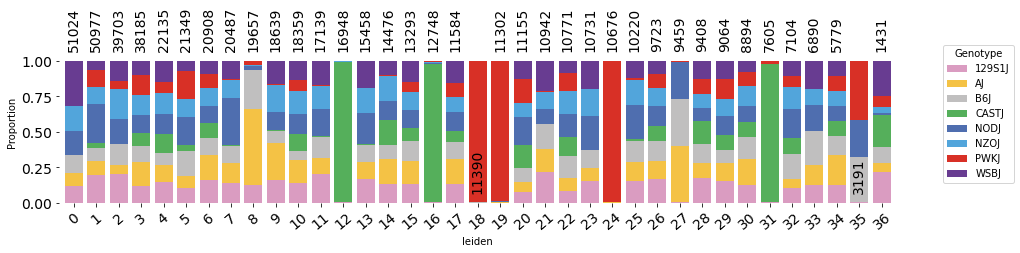

In [57]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'Genotype',
                            flip=False, fsize = (15,3), 
                            annotations = True)


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


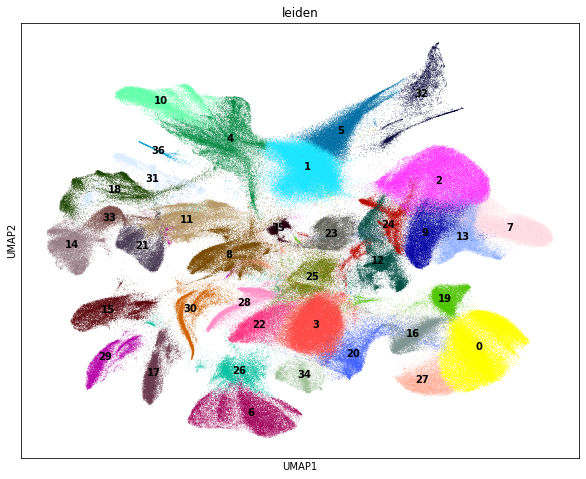

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


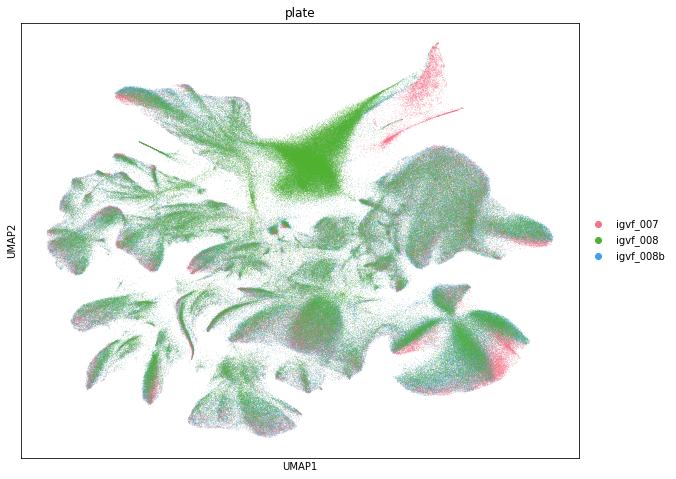

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


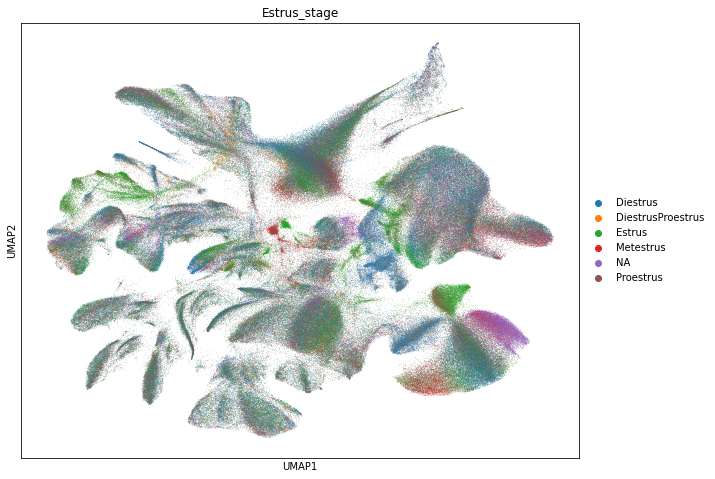

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


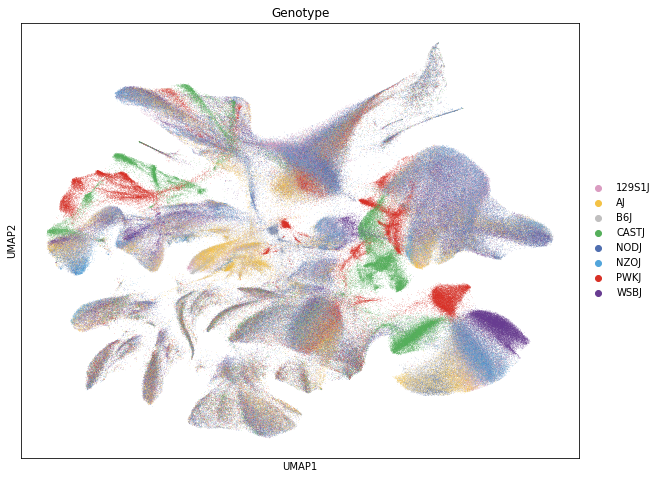

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


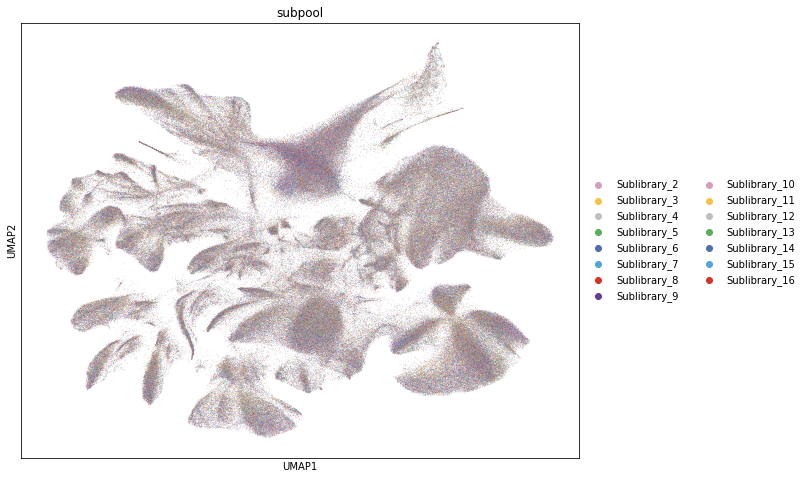

In [68]:
plt.rcParams['figure.figsize'] = (10, 8)

sc.pl.umap(adata, color=['leiden'], size=1, legend_loc = 'on data')

sc.pl.umap(adata, color=['plate'], size = 0.8, palette = plate_palette)

sc.pl.umap(adata, color=['Estrus_stage'], size = 0.8)

sc.pl.umap(adata, color=['Genotype'], size = 0.8, palette = geno_palette)

sc.pl.umap(adata, color=['subpool'], size = 0.8, palette = geno_palette)




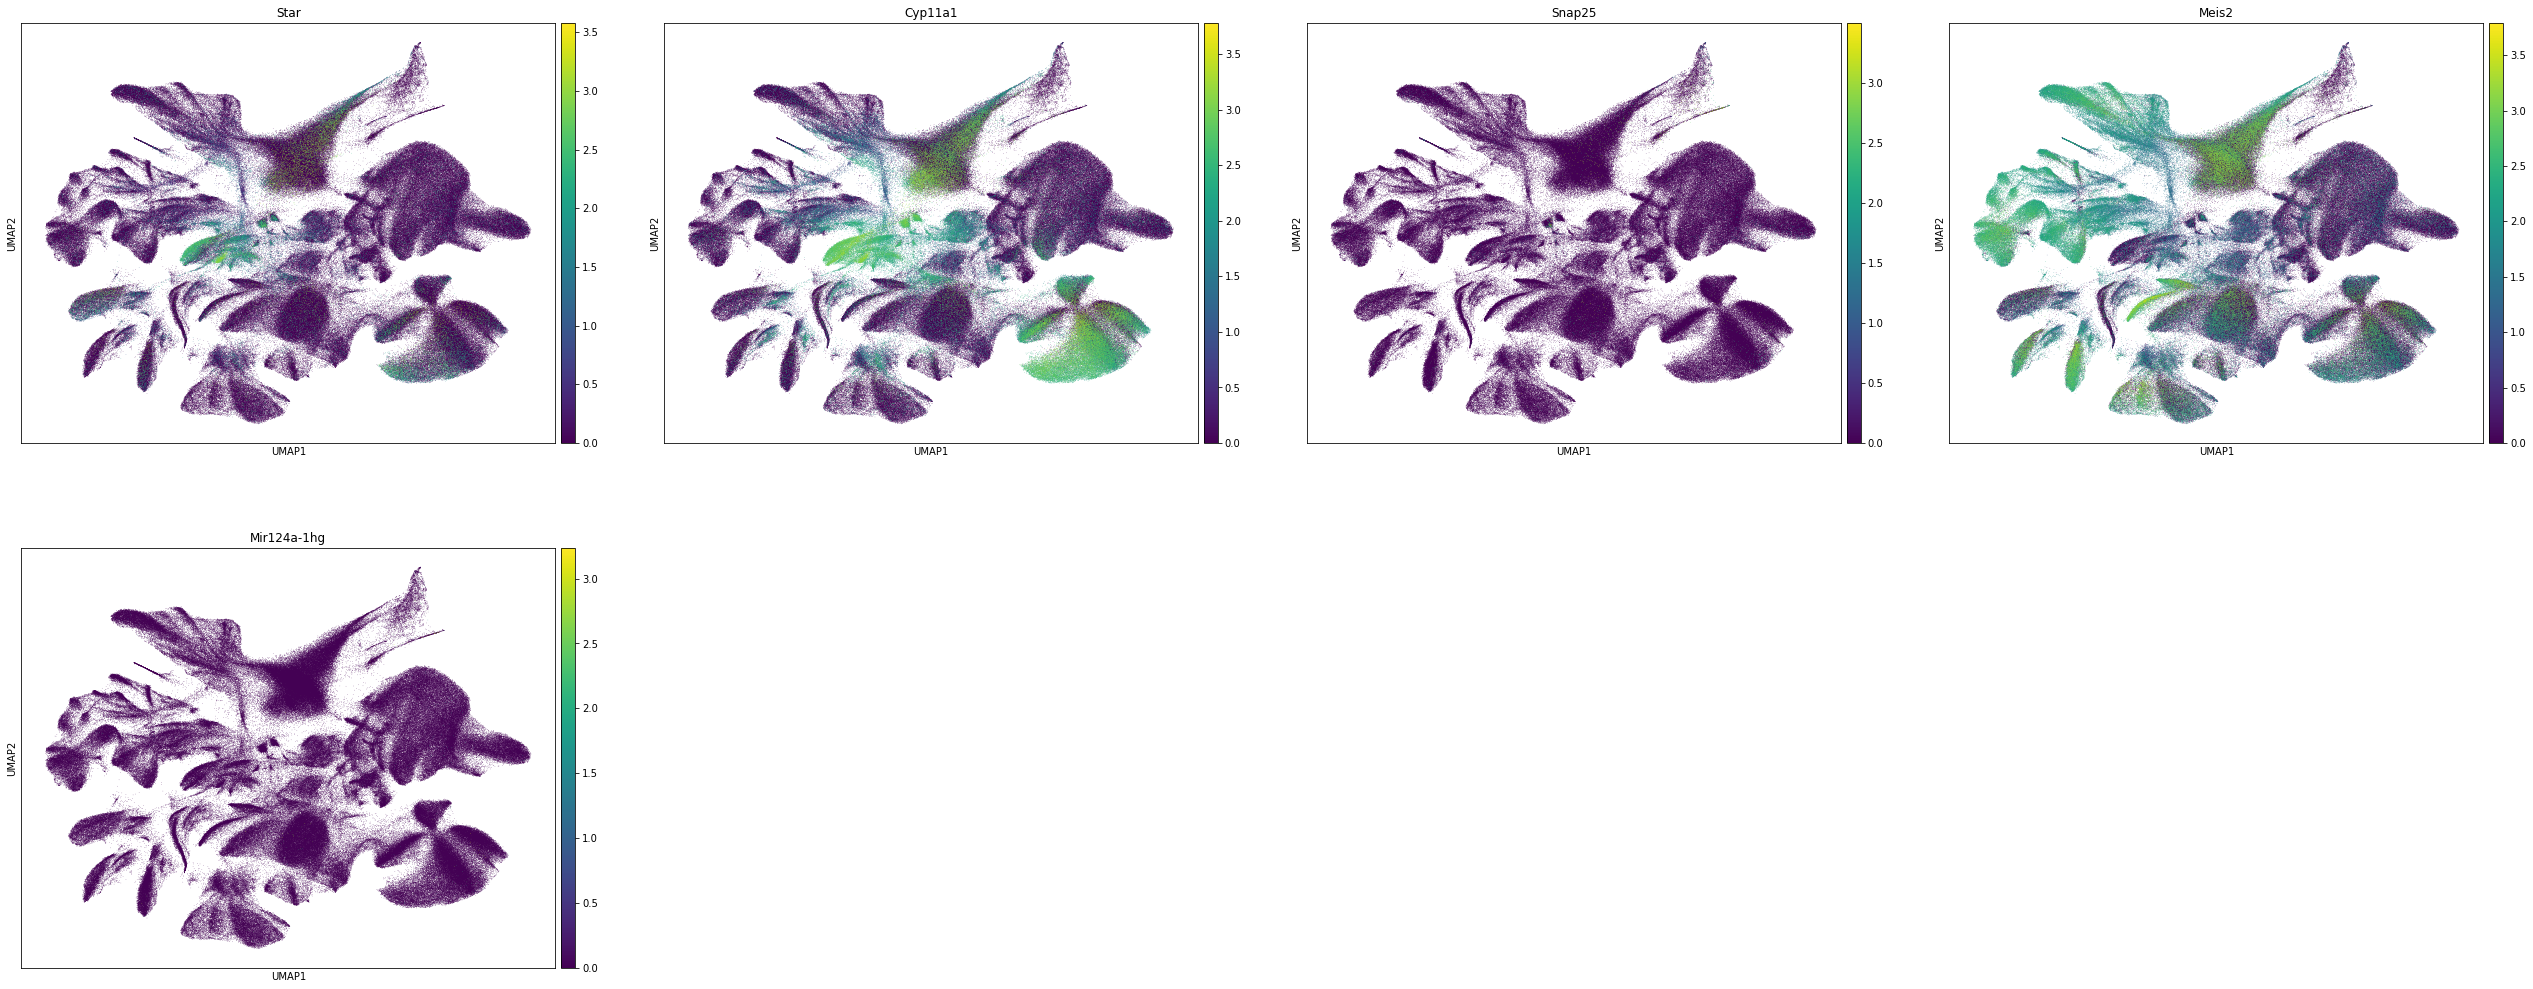

In [96]:
sc.pl.umap(adata, color=['Star','Cyp11a1','Snap25','Meis2','Mir124a-1hg'], size = 1)


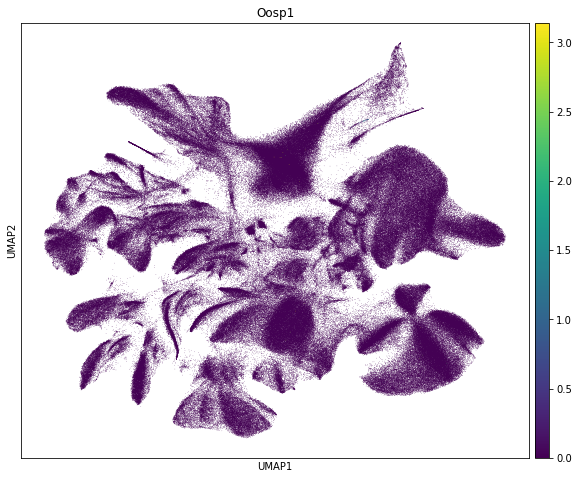

In [97]:

sc.pl.umap(adata, color=['Oosp1'], size = 1)


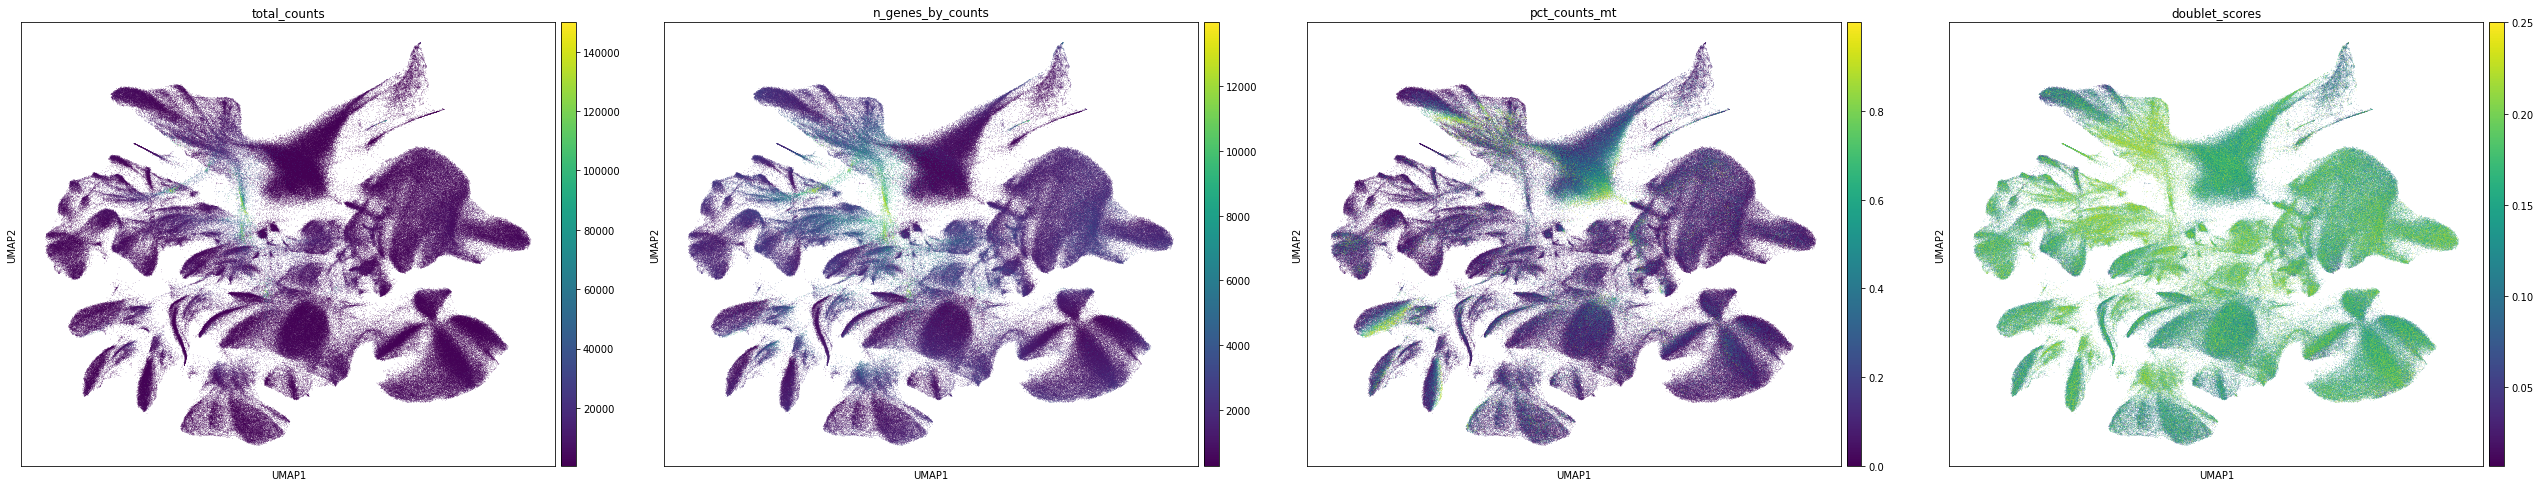

In [72]:
sc.pl.umap(adata, color=['total_counts','n_genes_by_counts','pct_counts_mt', 'doublet_scores'], size = 1)


# Over-representation analysis of my marker genes

Live markers link: https://docs.google.com/spreadsheets/d/1RJHnxeobFfXAQdrUGAn4SWxQZzs0KaheuLJgNc6AjCg/edit#gid=0

In [80]:
my_markers_df = pd.read_csv("IGVF_curated_markers.csv")
my_markers_df = my_markers_df[my_markers_df['Gene'].isin(adata.var_names)]
my_markers_df = my_markers_df[my_markers_df['Tissue'] == 'GonadsFemale']
my_markers_df['gene_name'] = my_markers_df['Gene']
my_markers_df = my_markers_df.drop_duplicates(subset=['Subtype', 'gene_name'])


In [82]:
adata.raw = adata


In [83]:
dc.run_ora(
    mat=adata,
    net=my_markers_df,
    source='Subtype',
    target='gene_name',
    min_n=3,
    verbose=True
)


8755 features of mat are empty, they will be removed.
Running ora on mat with 588804 samples and 48198 targets for 19 sources.


100%|██████████| 588804/588804 [22:50<00:00, 429.69it/s]  


In [85]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts


AnnData object with n_obs × n_vars = 588804 × 19
    obs: 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'subpool', 'bc1_well', 'bc2_well', 'bc3_well', 'Mouse_Tissue_ID', 'alias_tissue1', 'alias_tissue2', 'alias_tissue3', 'alias_tissue4', 'plate', 'Protocol', 'Chemistry', 'well_type', 'Row', 'Column', 'Genotype', 'Notes', 'Multiplexed_sample1', 'Multiplexed_sample2', 'SampleType', 'Tissue', 'Tissue_ID', 'Tissue1_ontology_id', 'Tissue2_ontology_id', 'Sex', 'Replicate', 'DOB', 'Age_weeks', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Dissector', 'Tissue_weight_mg', 'mult_genotype_1', 'mult_genotype_2', 'mult_genotype', 'n_counts', 'WSBJ', 'NZOJ', '129S1J', 'CASTJ', 'B6J', 'NODJ', 'AJ', 'PWKJ', 'doublet_scores', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'Estrus_stage'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'umap', 'dendrogram_leiden', 'leiden_colors', 'plate_colors', 'Estrus

In [86]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()


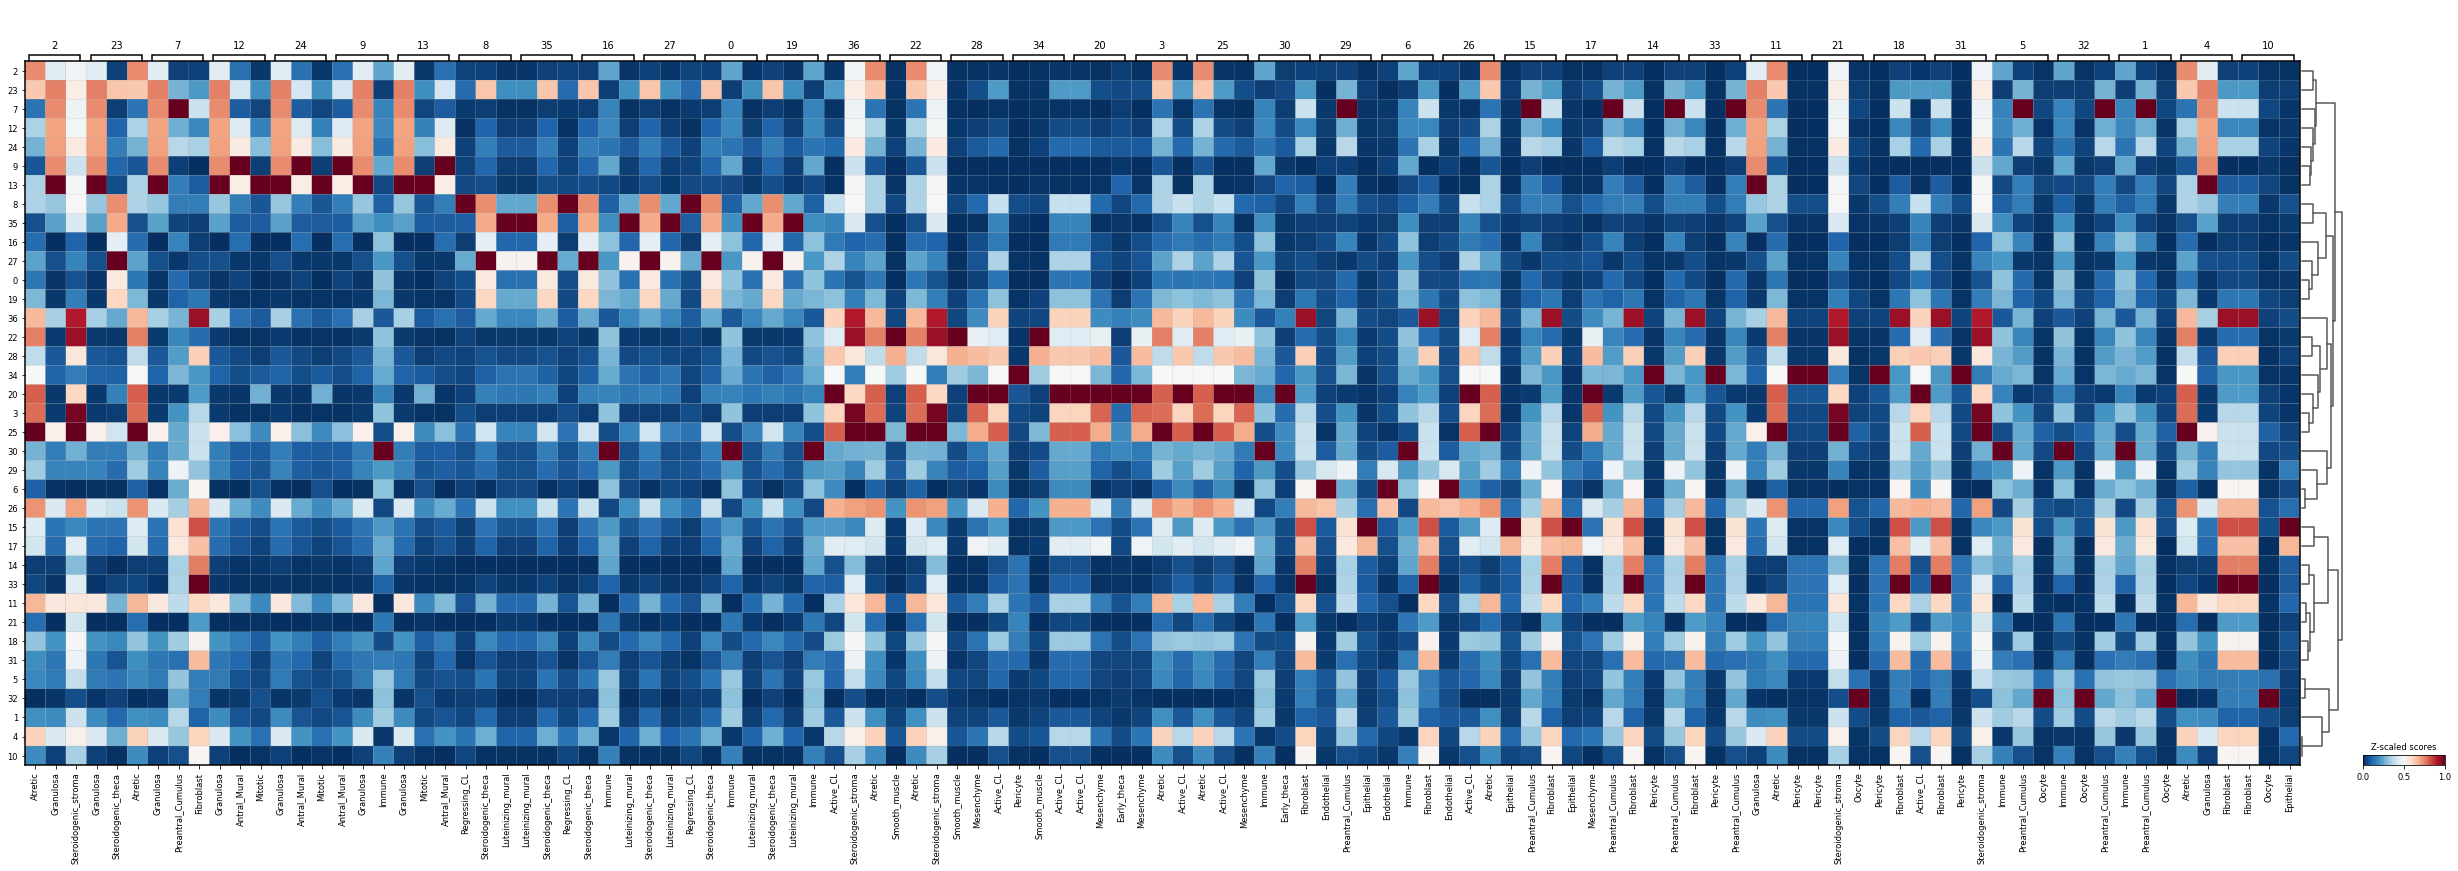

In [87]:
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')


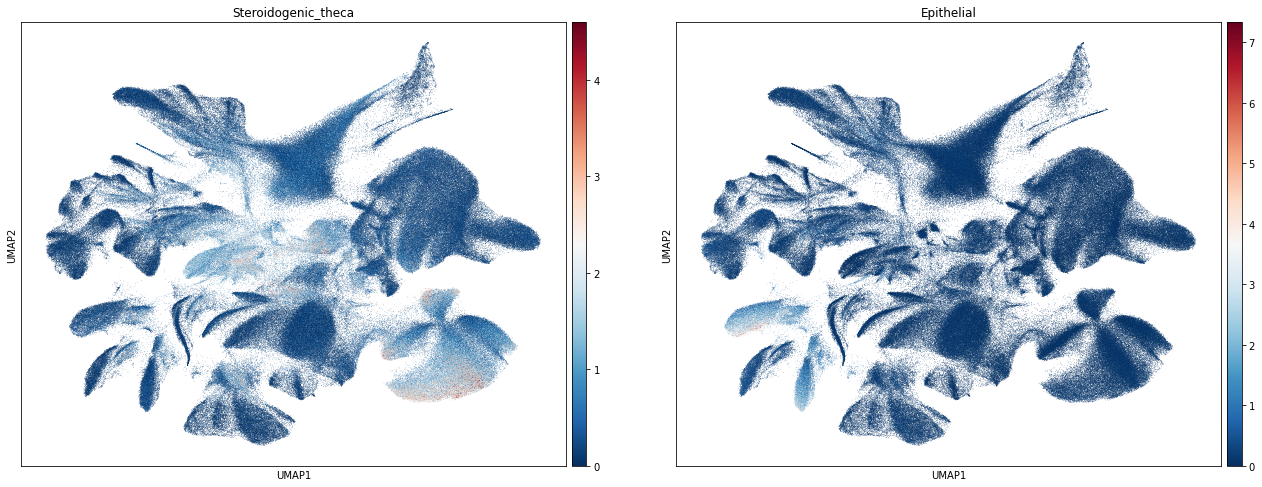

In [99]:
plt.rcParams['figure.figsize'] = (10, 8)

sc.pl.umap(acts, color=['Steroidogenic_theca','Epithelial'], size=1, cmap='RdBu_r')



# Check marker gene expression

In [93]:
marker_genes_dict = {
    "Granulosa": ["Nr5a2","Bex4","Fst","Hsd17b1",
                  "Slc18a2","Inha","Serpine2","Ivns1abp","Fam13a"]

}



In [102]:
marker_genes_dict = {
    "Oocyte": ["Gdf9","Khdc1b","Nlrp14","Ooep",
                  "Oosp1","Padi6","Rfpl4"]

}



categories: 0, 1, 2, etc.
var_group_labels: Oocyte


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


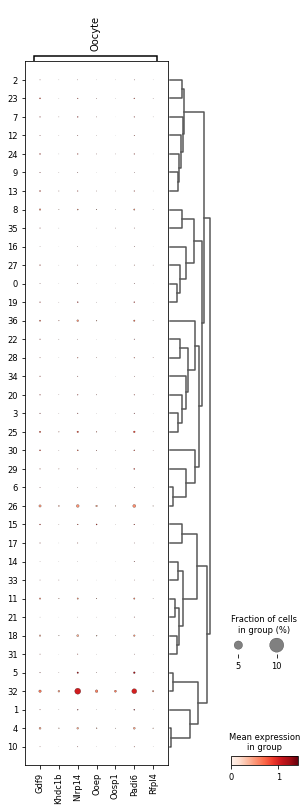

In [103]:
sc.pl.dotplot(adata, marker_genes_dict, 'leiden', mean_only_expressed = True,
              dendrogram=True, log=True)


In [58]:
marker_genes_dict = {
    "Adipocyte": ["Adipoq","Pnpla2"],
    "Endothelial": ["Flt1","Pecam1","Tie1","Kdr","Tek","Eng","Emcn"],
    "Lymphatic_endothelial": ["Prox1","Lyve1","Flt4"],
    "Endocardial": ["Nrg2","Sox17"],
    "Fibroblast": ["Mgp","Dcn","Col1a1","Pdgfra","Ddr2"],
    "Macrophage": ["Mrc1","Adgre1","Itgam","Fcgr1","Cx3cr1","F13a1"],
    "Lymphocyte": ["Ms4a1","Ikzf1","Ikzf3","Bcl11a","Themis","Il7r"],
    "Smooth_muscle": ["Myh11","Mylk","Acta2","Tagln","Eln","Myl6","Myl9"],
    "Pericyte": ["Pdgfrb","P2ry14","Abcc9"],
    "Schwann": ["Cadm2","Sox10","Postn","Plp1"],
    "Epicardial": ["Abi1","Wt1","Aldh1a2"],
    "Epithelial": ["Cdh1","Klf5"],
    "Granulosa": ["Nr5a2","Bex4","Fst","Hsd17b1","Slc18a2","Inha","Serpine2","Ivns1abp","Fam13a"],
    "Cardiomyocyte": ["Ryr2","Ttn","Actc1","Tnnt2","Tnnc1","Mybpc3","Myh6","Myh7","Atp2a2","Gata4","Mef2a","Mef2d"],
    "Cycling": ["Top2a","Mki67"],
    "Neuron": ["Snap25","Slc17a7"],
    "Adrenal": ["Star"],

}



In [59]:
adata.var_names  = adata.var['gene_name']


categories: 0, 1, 2, etc.
var_group_labels: Adipocyte, Endothelial, Lymphatic_endothelial, etc.


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


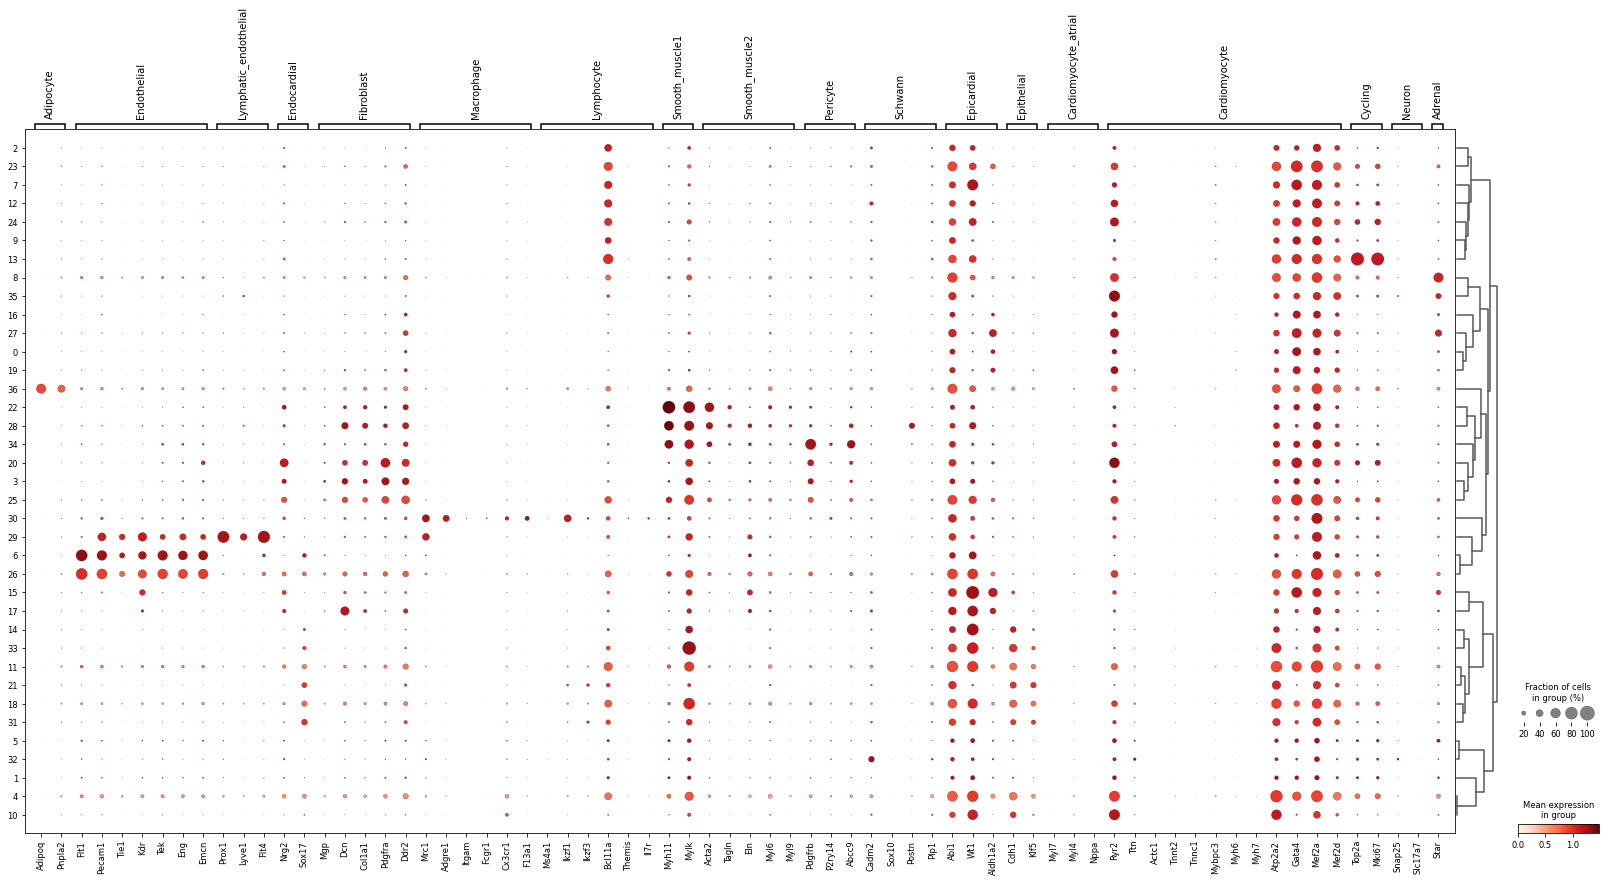

In [60]:
sc.pl.dotplot(adata, marker_genes_dict, 'leiden', mean_only_expressed = True,
              dendrogram=True, log=True)


In [61]:
smol_marker_genes_dict = {
    "Adipocyte": ["Adipoq"],
    "Endothelial": ["Flt1","Pecam1"],
    "Lymphatic_endothelial": ["Prox1"],
    "Endocardial": ["Sox17"],
    "Fibroblast": ["Dcn","Pdgfra"],
    "Macrophage": ["F13a1"],
    "B_cell": ["Bcl11a"],
    "T_cell": ["Themis"],
    "Smooth_muscle1": ["Myh11","Mylk"],
    "Smooth_muscle2": ["Eln","Tagln"],
    "Pericyte": ["Pdgfrb","P2ry14"],
    "Schwann1": ["Mpz", "Pmp22", "Prx"], # myelinating
    "Schwann2": ["Scn7a","Ncam1","Slc35f1"], # non-myelinating
    "Epicardial": ["Wt1","Aldh1a2"],
    "Epithelial": ["Cdh1","Klf5"],
    "Cardiomyocyte_atrial": ['Myl7','Myl4','Nppa'],
    "Cardiomyocyte": ["Ryr2","Tnnt2","Mybpc3","Myh7","Gata4","Mef2d"],
    "Cycling": ["Top2a","Mki67"],
    "Neuron": ["Snap25","Slc17a7"],
    "Adrenal": ["Star"],

}


categories: 0, 1, 2, etc.
var_group_labels: Adipocyte, Endothelial, Lymphatic_endothelial, etc.


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


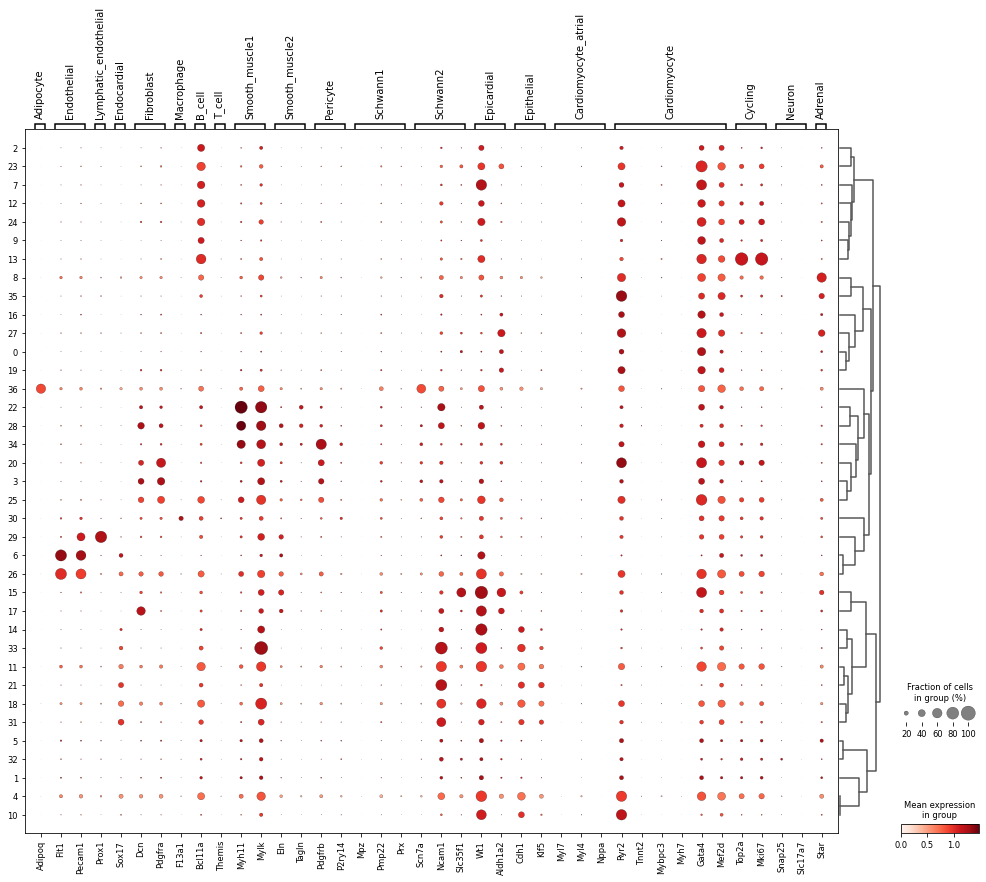

In [62]:
sc.pl.dotplot(adata, smol_marker_genes_dict, 'leiden', mean_only_expressed = True,
              dendrogram=True, log=True)


# Assign celltypes to clusters

In [62]:
annots = pd.read_csv("Heart_annotations.csv")
annots['leiden'] = annots['leiden'].astype(str)
annotation_dict = annots.groupby('leiden').head(1).set_index('leiden')['celltype'].to_dict()


In [63]:
adata.obs['celltype'] = adata.obs['leiden'].map(annotation_dict)

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


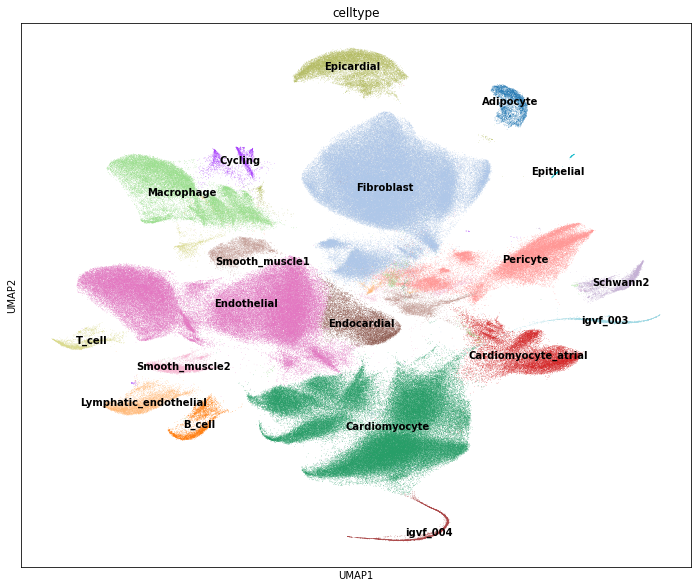

In [64]:
plt.rcParams['figure.figsize'] = (12, 10)

sc.pl.umap(adata, color=['celltype'], size=1, legend_loc = 'on data')


In [65]:
sc.tl.dendrogram(adata, groupby = 'celltype')

categories: Adipocyte, B_cell, Cardiomyocyte, etc.
var_group_labels: Adipocyte, Endothelial, Lymphatic_endothelial, etc.


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


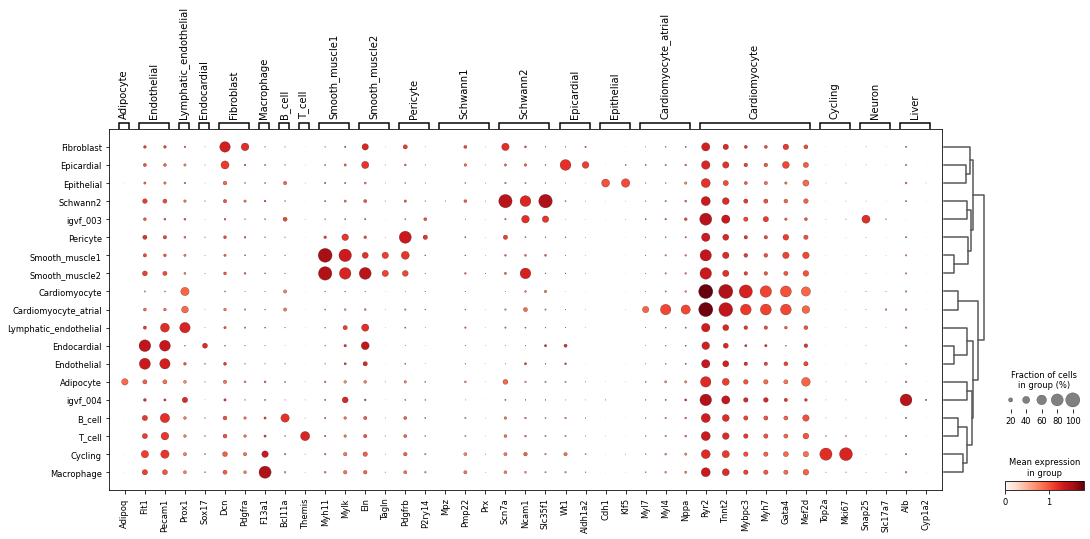

In [66]:
sc.pl.dotplot(adata, smol_marker_genes_dict, 'celltype', mean_only_expressed = True,
              dendrogram=True, log=True)


# Save annotated adata

In [67]:
adata.write_h5ad('../IGVF_analysis/annotated_tissues/Heart_annotated.h5ad')
